<a href="https://www.kaggle.com/code/ysraeldjs/efficient-net-ic-ysrael-e-diogo-luna16-ufs?scriptVersionId=236890825" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importaçao dos dados

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/luna16/sampleSubmission.csv
/kaggle/input/luna16/annotations.csv
/kaggle/input/luna16/candidates.csv
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.212346425055214308006918165305.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.281967919138248195763602360723.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739.raw
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.283569726884265181140892667131.raw
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.192256506776434538421891524301.raw
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.113586291551175790743673929831.raw
/kaggle/input/luna16/subset2/subset2/

In [2]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
import skimage
from skimage import measure, morphology, segmentation
from tqdm.notebook import tqdm
import scipy.ndimage as ndimage

# Verificação e validação do dataset

In [3]:
!ls "/kaggle/input/luna16"

annotations.csv  evaluationScript      subset0	subset3
candidates.csv	 sampleSubmission.csv  subset1	subset4
candidates_V2	 seg-lungs-LUNA16      subset2


Ao verificar o dataset, foi descoberto que alguns `seriesuids` no arquivo `annotations.csv` não possuem informações correspondentes de tomografias (CT scans).

O mesmo problema também foi encontrado no trabalho de outro autor:
https://www.kaggle.com/code/mashruravi/pytorch-vs-cancer

Dados ausentes¶

Existem alguns `seriesuids` no dataset que não têm tomografias correspondentes.

Eu farei uma limpeza nos dados antes de começar o treinamento do modelo U-net.

In [4]:
# annotations.csv A localização dos nódulos pulmonares marcados pelo médico foi registrada
import pandas as pd

annotations_df = pd.read_csv("/kaggle/input/luna16/annotations.csv")
print(annotations_df.head())

                                           seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   

       coordZ  diameter_mm  
0 -298.387506     5.651471  
1 -227.121250     4.224708  
2  876.374496     5.786348  
3 -391.081276     8.143262  
4 -405.493732    18.545150  


# mhd para fatias, e seleção do pulmão(Por criação de mascara para seleção)

/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760173137525888934217.mhd


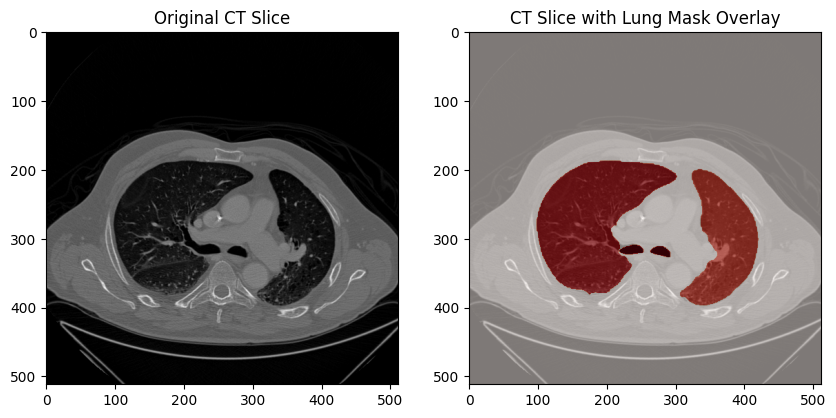

In [5]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os 

def load_ct_and_mask(seriesuid, luna16_input_path="/kaggle/input/luna16"):
    """
    Entradas: 
    .seriesuid -> nome do arquivo 
    luna16_input_path -> caminho do dataset(Constante)

    Saídas:
    ct_array, 
    mask_array, 
    spacing, 
    ct_path
    """
    ct_path = None #Nulo
    for subset_index in range(5): # Do subset 0 ao 4
        temp_ct_path = f"{luna16_input_path}/subset{subset_index}/subset{subset_index}/{seriesuid}.mhd"
        if os.path.exists(temp_ct_path): # Verifique se o arquivo existe
            ct_path = temp_ct_path
            print(ct_path)
            break # Encontre o caminho do TC e saia do loop
    if ct_path is None:
        raise FileNotFoundError(f"CT Image file not found for seriesuid: {seriesuid}") # Se nenhum for encontrado, gere um erro

    mask_path = f"{luna16_input_path}/seg-lungs-LUNA16/seg-lungs-LUNA16/{seriesuid}.mhd" 
    
    ct_image = sitk.ReadImage(ct_path)
    mask_image = sitk.ReadImage(mask_path)

    ct_array = sitk.GetArrayFromImage(ct_image)
    mask_array = sitk.GetArrayFromImage(mask_image)
    spacing = np.array(ct_image.GetSpacing())

    return ct_array, mask_array, spacing, ct_path

# verificação
sample_seriesuid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760173137525888934217" # Selecione um seriesuid para teste
ct_array, mask_array, spacing, ct_path = load_ct_and_mask(sample_seriesuid)


"""
#DEBUG
print("CT array shape:", ct_array.shape)
print("Mask array shape:", mask_array.shape)
print("Spacing:", spacing)
"""

slice_index = ct_array.shape[0] // 2 # Pegue a fatia do meio

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(ct_array[slice_index], cmap='gray')
plt.title("Original CT Slice")

plt.subplot(1, 2, 2)
plt.imshow(ct_array[slice_index], cmap='gray') #CT slice
plt.imshow(mask_array[slice_index], cmap='Reds', alpha=0.5) # mask
plt.title("CT Slice with Lung Mask Overlay")

plt.show()

In [6]:
# # beta 加入 direction 與 origin
# import os
# import SimpleITK as sitk
# import numpy as np
# import pydicom # Import pydicom if you need to read DICOM metadata later

# def load_ct_and_mask(seriesuid, luna16_input_path="/kaggle/input/luna16"):
#     """
#     根據 seriesuid 載入 CT 影像和肺部分割 mask (修正 subset 路徑問題), 並返回元數據 (使用 SimpleITK.ReadImage for MHD).
#     """
#     ct_path = None
#     for subset_index in range(5): # 依序檢查 subset0 到 subset4
#         temp_ct_path = f"{luna16_input_path}/subset{subset_index}/subset{subset_index}/{seriesuid}.mhd"
#         if os.path.exists(temp_ct_path):
#             ct_path = temp_ct_path
#             print(ct_path) # 印出 CT 路徑
#             break # 找到 CT 路徑就跳出迴圈
#     if ct_path is None:
#         raise FileNotFoundError(f"CT Image file not found for seriesuid: {seriesuid}") # 如果都沒找到，拋出錯誤

#     mask_path = f"{luna16_input_path}/seg-lungs-LUNA16/seg-lungs-LUNA16/{seriesuid}.mhd"

#     # --- Use SimpleITK.ReadImage to read MHD file directly ---
#     ct_image = sitk.ReadImage(ct_path) # Read MHD directly
#     mask_image = sitk.ReadImage(mask_path) # Read mask MHD directly

#     ct_array = sitk.GetArrayFromImage(ct_image)
#     mask_array = sitk.GetArrayFromImage(mask_image)
#     spacing = np.array(ct_image.GetSpacing())
#     origin = np.array(ct_image.GetOrigin()) # Get origin metadata
#     direction = np.array(ct_image.GetDirection()).reshape(3, 3) # Get direction matrix metadata

#     return ct_array, mask_array, spacing, origin, direction, ct_path # Return spacing, origin, direction metadata

# # 選擇一個 seriesuid 進行測試 
# sample_seriesuid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259572521472765997306"

# ct_array, mask_array, spacing, ct_path = load_ct_and_mask(sample_seriesuid)

# print("CT array shape:", ct_array.shape)
# print("Mask array shape:", mask_array.shape)
# print("Spacing:", spacing)
# print("Origin", origin)
# print("direction", direction)


# slice_index = ct_array.shape[0] // 2 # 取中間切片

# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.imshow(ct_array[slice_index], cmap='gray')
# plt.title("Original CT Slice")

# plt.subplot(1, 2, 2)
# plt.imshow(ct_array[slice_index], cmap='gray') # 先顯示 CT slice
# plt.imshow(mask_array[slice_index], cmap='Reds', alpha=0.5) # 疊加肺部 mask，紅色半透明
# plt.title("CT Slice with Lung Mask Overlay")

# plt.show()

In [7]:
# Normalização de valores em escala de cinza

def normalize_ct_image(ct_array):
    """
    Normalizar os valores de escala de cinza da imagem de TC para o intervalo [0, 1] (versão de depuração 2).

    Entrada: 
    ct_array -> Array do CT 

    Saída:
    ct_array_normalized -> array normalizado de cinza para 
    
    """

    """
    #DEBUG
    print(f"normalize_ct_image: Input ct_array dtype: {ct_array.dtype}") # Imprimir tipo de dados de entrada
    print(f"normalize_ct_image: Input ct_array.min() = {ct_array.min()}, Input ct_array.max() = {ct_array.max()}") # Imprima o intervalo de valores de escala de cinza de entrada
    """
    
    min_val = -1000  # HU Inferior
    max_val = 400    # HU Superior Pesquisar o que é HU

    #Todos os prints vão estar em comentários 
    #print(f"normalize_ct_image: min_val = {min_val}, max_val = {max_val}")

    ct_array_clipped = np.clip(ct_array, min_val, max_val) # Recorte o intervalo de valores em tons de cinza
    #print(f"normalize_ct_image: ct_array_clipped.min() = {ct_array_clipped.min()}, ct_array_clipped.max() = {ct_array_clipped.max()}") # Imprima o intervalo de valores em tons de cinza recortados

    denominator = (max_val - min_val)
    #print(f"normalize_ct_image: denominator (max_val - min_val) = {denominator}") 

    if denominator == 0: # Verifique se o denominador é 0 para evitar erros de divisão por 0
        ct_array_normalized = np.zeros_like(ct_array_clipped, dtype=np.float32) # Se o denominador for 0, retorne uma imagem de todos os 0s

        ct_array_normalized = (ct_array_clipped - min_val) / denominator # Escala linear para [0, 1]
    else:
        ct_array_normalized = (ct_array_clipped - min_val) / denominator
        
    ct_array_normalized = ct_array_normalized.astype(np.float32) # Forçar conversão do tipo de dados para float32!

    #print(f"preprocess_ct_scan: Before return - ct_array_normalized.min() = {ct_array_normalized.min()}, ct_array_normalized.max() = {ct_array_normalized.max()}, dtype = {ct_array_normalized.dtype}") # 在 return 之前再次印出

    return ct_array_normalized

In [8]:
# Use a máscara de segmentação pulmonar para extrair a ROI do pulmão da imagem de TC
#Tira o que realmente importa!

def extract_lung_roi(ct_array, mask_array):
    """
    Use a máscara de segmentação pulmonar para extrair a ROI do pulmão da imagem de TC

    Entrada: 
    ct_array -> array do exame 
    mask_array -> array marcado

    Saída: 
    array de informaçoes úteis -> roi_array
    
    """
    roi_array = ct_array.copy() # Faça uma cópia do ct_array para evitar modificar a imagem original
    roi_array[mask_array == 0] = 0 # Defina o valor de pixel da área onde a máscara é 0 (fora dos pulmões) como 0, e o valor de pixel da área do pulmão permanece inalterado
    return roi_array

In [9]:
# Integre normalize_ct_image e extract_lung_roi em uma função preprocess_ct_scan para uso subsequente:

def preprocess_ct_scan(ct_array, mask_array):
    """
        As imagens de TC foram pré-processadas: normalização do valor de cinza e extração do ROI do pulmão.
        
        Entrada:
        ct_array: matriz NumPy (Z, Y, X) de imagens de TC
        mask_array: array NumPy (Z, Y, X) de máscara de segmentação pulmonar, com valores de 0 ou 1
        
        Saída:
        preprocessed_array: matriz NumPy de imagem de TC pré-processada (Z, Y, X), valor em escala de cinza [0, 1], valor de pixel fora da área do pulmão é 0
    """
    normalized_array = normalize_ct_image(ct_array) # Normalização do valor de cinza
    roi_array = extract_lung_roi(normalized_array, mask_array) # Extração de ROI pulmonar
    return roi_array

/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275.mhd


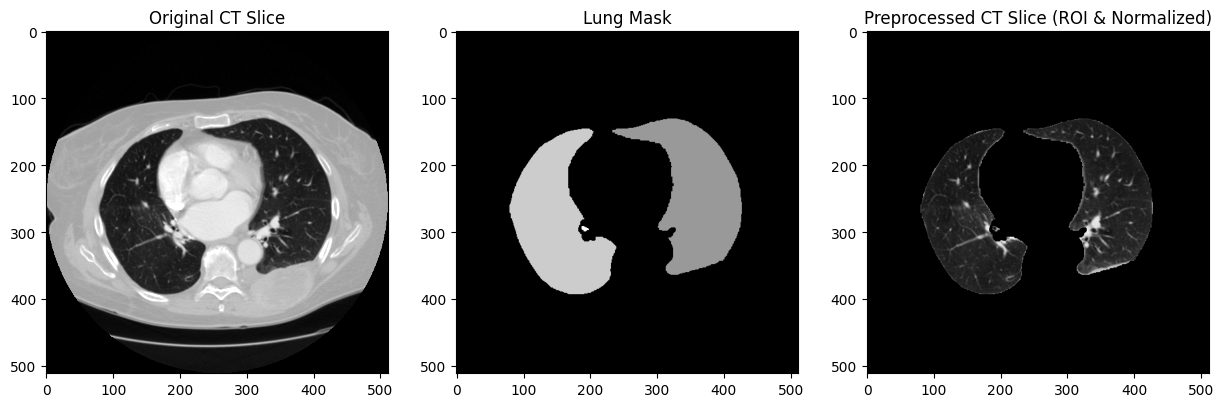

Preprocessed slice min value: 0.0000, max value: 1.0000


In [10]:
#Verifique o efeito do pré-processamento

# Selecione um seriesuid para teste
sample_seriesuid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275"

ct_array, mask_array, spacing, ct_path = load_ct_and_mask(sample_seriesuid)
preprocessed_array = preprocess_ct_scan(ct_array, mask_array)
preprocessed_slice = preprocessed_array[ct_array.shape[0] // 2] # Obtenha a fatia intermediária pré-processada

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(ct_array[ct_array.shape[0] // 2], cmap='gray', vmin=-1000, vmax=400)
plt.title("Original CT Slice")

plt.subplot(1, 3, 2)
plt.imshow(mask_array[ct_array.shape[0] // 2], cmap='gray')
plt.title("Lung Mask")

plt.subplot(1, 3, 3)
plt.imshow(preprocessed_slice, cmap='gray', vmin=0, vmax=1)
plt.title("Preprocessed CT Slice (ROI & Normalized)")

plt.show()

print(f"Preprocessed slice min value: {preprocessed_slice.min():.4f}, max value: {preprocessed_slice.max():.4f}")


In [11]:
# Gerar máscaras de segmentação de nódulos para tomografia computadorizada
def generate_nodule_masks(seriesuid, ct_array, annotations_df, luna16_input_path="/kaggle/input/luna16"):
    """
    Gerar máscaras de segmentação de nódulos para tomografias computadorizadas

    Entradas: 
    seriesuid
    ct_array 
    annotations_df -> dataset que contém as coordenadas dos nódulos
    luna16path 

    Saída: 
    Mascaras dos nódulos
    """

    # Array vazio, com o mesmo shape de ct_array ----> será usado!
    nodule_masks = np.zeros(ct_array.shape, dtype=np.uint8)

    #Pega a linha de acordo com o seriesuid
    scan_annotations = annotations_df[annotations_df['seriesuid'] == seriesuid]

    
    # --- Obtenha a origem, espaçamento e direção das imagens de TC ---
    ct_path = None
    for subset_index in range(5): # do sub0 ao 4
        temp_ct_path = f"{luna16_input_path}/subset{subset_index}/subset{subset_index}/{seriesuid}.mhd"
        if os.path.exists(temp_ct_path):
            ct_path = temp_ct_path
            break
    
    if ct_path is None:
        raise FileNotFoundError(f"未找到 seriesuid: {seriesuid} 的 CT 影像檔案")
    
    # Use SimpleITK para ler o arquivo mhd e obter os metadados
    mhd_file = sitk.ReadImage(ct_path) 
    origin_xyz = np.array(mhd_file.GetOrigin())      # Obtenha as coordenadas de origem (X,Y,Z)
    spacing_xyz = np.array(mhd_file.GetSpacing())    # Obter espaçamento de voxel (X,Y,Z)
    direction_matrix = np.array(mhd_file.GetDirection()).reshape(3, 3)  # Obter a matriz de direção
    
    # --- Aquisição de metadados concluída ---
    for _, annotation in scan_annotations.iterrows():
        # Obtenha as coordenadas mundiais (X,Y,Z) e o diâmetro do nódulo
        center_world = np.array([annotation.coordX, annotation.coordY, annotation.coordZ])
        diameter_mm = annotation.diameter_mm
        
        # --- Conversão de coordenadas mundiais (X,Y,Z) para coordenadas de voxel (I,J,K) ---
        # Nota: O sistema de coordenadas do SimpleITK é (I,J,K) = (X,Y,Z), mas a indexação de array NumPy é (K,J,I) = (Z,Y,X)
        # 1. Primeiro, calcule a transformação das coordenadas mundiais em coordenadas voxel contínuas (levando em consideração a matriz de orientação)
        center_voxel_ijk = np.linalg.solve(direction_matrix, (center_world - origin_xyz) / spacing_xyz)
        
        # 2. Arredonde as coordenadas contínuas do voxel para o índice inteiro mais próximo e converta (I,J,K) para a ordem (Z,Y,X) do NumPy
        center_zyx = np.round(center_voxel_ijk[::-1]).astype(int)  # 翻轉順序變成 (Z,Y,X)
        
        # 3. Calcular o raio do nódulo (em pixels)
        # Use o espaçamento X para calcular (LUNA16 geralmente tem o mesmo espaçamento nas direções X e Y)
        radius_pixel = int(round(diameter_mm / (2 * spacing_xyz[0])))
        
        #print(f"Debug - 結節資訊: 世界座標 (X,Y,Z): {center_world}, 体素座標 (Z,Y,X): {center_zyx}, 直徑: {diameter_mm}mm, 半徑: {radius_pixel}px")
        
        """
        --- Desenhe nódulos em cada fatia ---
        Determine o intervalo de corte onde os nódulos podem aparecer (direção Z)
        """
        z_min = max(0, center_zyx[0] - radius_pixel)
        z_max = min(ct_array.shape[0] - 1, center_zyx[0] + radius_pixel)
        
        # Processar cada fatia no intervalo
        for z_index in range(z_min, z_max + 1):
            current_mask_slice = nodule_masks[z_index]
            
            # Ajuste o raio do nódulo na fatia atual (opcional: ajuste o tamanho do círculo com base na distância da fatia central)
            distance_from_center = abs(z_index - center_zyx[0])
            if distance_from_center > radius_pixel:  # 超出半徑範圍則跳過
                continue
                
            # Opcional: ajuste o raio do círculo com base na distância do centro (para criar um efeito elipsóide)
            current_radius = radius_pixel  # 簡化版本: 所有切片使用相同半徑
            
            # Obtenha as coordenadas YX da fatia atual (correspondentes à linha, coluna da imagem de varredura)
            center_yx = center_zyx[1:3]  # 獲取 (Y,X) 部分
            
            # Verificação de limites
            if (center_yx[0] < 0 or center_yx[0] >= current_mask_slice.shape[0] or
                center_yx[1] < 0 or center_yx[1] >= current_mask_slice.shape[1]):
                #print(f"警告: 中心點 {center_yx} 超出切片邊界 {current_mask_slice.shape}")
                continue
                
            try:
                # Chame skimage.draw.disk para desenhar o círculo (usando o formato row, col)
                rr, cc = skimage.draw.disk(center_yx, current_radius, shape=current_mask_slice.shape)
                current_mask_slice[rr, cc] = 1
                #print(f"Debug - Drawing disk on slice {z_index}: center (Y,X): {center_yx}, radius: {current_radius}px, pixels set: {len(rr)}")
            except Exception as e:
                print(f"Error drawing disk on slice {z_index}: {e}")
                
    #print(f"Debug - generate_nodule_masks: Final nodule_masks sum: {nodule_masks.sum()}")
    return nodule_masks

In [12]:
def calculate_nodule_center(nodule_annotation, ct_array, ct_path):
    """Calcule a posição do índice do nódulo no volume da TC a partir das informações de anotação"""
    # Ler metadados de TC
    mhd_file = sitk.ReadImage(ct_path)
    origin_xyz = np.array(mhd_file.GetOrigin())
    spacing_xyz = np.array(mhd_file.GetSpacing())
    direction_matrix = np.array(mhd_file.GetDirection()).reshape(3, 3)
    
    # Obtenha as coordenadas mundiais do nódulo
    center_world = np.array([nodule_annotation.coordX, 
                             nodule_annotation.coordY, 
                             nodule_annotation.coordZ])
    
    # Converter para coordenadas de voxel
    center_voxel_ijk = np.linalg.solve(direction_matrix, 
                                       (center_world - origin_xyz) / spacing_xyz)
    
    # Converter para ordem ZYX
    center_zyx = np.round(center_voxel_ijk[::-1]).astype(int)
    
    return center_zyx

def visualize_nodule_detection(seriesuid, ct_array, mask_array, nodule_masks, annotations_df, luna16_input_path="/kaggle/input/luna16"):
    """
        Visualize os resultados da detecção de nódulos pulmonares, incluindo TC original, segmentação pulmonar e localização do nódulo
        
        parâmetro:
        seriesuid: ID da tomografia computadorizada
        ct_array: dados de volume de TC
        mask_array: máscara de segmentação de pulmão
        nodule_masks: máscaras de nódulos geradas
        annotations_df: DataFrame contendo informações de anotação
        luna16_input_path: caminho do conjunto de dados LUNA16

        Saída: 
        Imagens para visualização
"""
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle
    import numpy as np
    
    # 1. Encontre a fatia com nódulos
    nodule_slices = np.where(nodule_masks.sum(axis=(1,2)) > 0)[0]
    
    if len(nodule_slices) == 0:
        #print("警告：未檢測到任何結節！")
        # Selecione várias fatias padrão
        num_slices = ct_array.shape[0]
        nodule_slices = [num_slices // 4, num_slices // 2, num_slices * 3 // 4]
    
    # Obtenha todas as anotações de nódulos para esta tomografia computadorizada
    scan_annotations = annotations_df[annotations_df['seriesuid'] == seriesuid]
    
    # 2. Visualize cada fatia com um nódulo
    for i, slice_idx in enumerate(nodule_slices):
        if i >= 3:  # Exibir até 3 fatias
            break
            
        plt.figure(figsize=(18, 6))
        
        # 2.1 Exibe cortes de TC originais
        plt.subplot(1, 4, 1)
        plt.imshow(ct_array[slice_idx], cmap='gray', vmin=-1000, vmax=400)
        plt.title(f"Original CT Slice #{slice_idx}")
        plt.axis('off')
        
        # 2.2 Exibe máscara de segmentação pulmonar
        plt.subplot(1, 4, 2)
        plt.imshow(ct_array[slice_idx], cmap='gray', vmin=-1000, vmax=400)
        plt.imshow(mask_array[slice_idx], cmap='Blues', alpha=0.3)
        plt.title(f"Lung segmentation #{slice_idx}")
        plt.axis('off')
        
        # 2.3 Exibe máscara de nódulo
        plt.subplot(1, 4, 3)
        plt.imshow(ct_array[slice_idx], cmap='gray', vmin=-1000, vmax=400)
        plt.imshow(nodule_masks[slice_idx], cmap='Reds', alpha=0.7)
        plt.title(f"Nodule Detection #{slice_idx}")
        plt.axis('off')
        
        # 2.4 Visualização combinada (pulmão + nódulos)
        plt.subplot(1, 4, 4)
        plt.imshow(ct_array[slice_idx], cmap='gray', vmin=-1000, vmax=400)
        plt.imshow(mask_array[slice_idx], cmap='Blues', alpha=0.3)
        plt.imshow(nodule_masks[slice_idx], cmap='Reds', alpha=0.7)
        plt.title(f"Overlay #{slice_idx}")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # 3. Visualização 3D - Três Vistas da Fatia Central
    if len(scan_annotations) > 0:
        plt.figure(figsize=(18, 6))
        
        # Encontre o caminho do arquivo CT
        ct_path = None
        for subset_index in range(5):
            temp_ct_path = f"{luna16_input_path}/subset{subset_index}/subset{subset_index}/{seriesuid}.mhd"
            if os.path.exists(temp_ct_path):
                ct_path = temp_ct_path
                break
        
        if ct_path is None:
            #print("警告：找不到CT文件，無法顯示三視圖！")
            return
        
        # Tome o primeiro nódulo como centro
        nodule_annotation = scan_annotations.iloc[0]
        
        # Obtenha a posição do índice do nódulo no volume da TC
        center_z, center_y, center_x = calculate_nodule_center(nodule_annotation, ct_array, ct_path)
        
        # Certifique-se de que o índice esteja no intervalo válido
        center_z = np.clip(center_z, 0, ct_array.shape[0]-1)
        center_y = np.clip(center_y, 0, ct_array.shape[1]-1)
        center_x = np.clip(center_x, 0, ct_array.shape[2]-1)
        
        # Exibir fatias em três direções
        plt.subplot(1, 3, 1)
        plt.imshow(ct_array[int(center_z)], cmap='gray', vmin=-1000, vmax=400)
        plt.imshow(nodule_masks[int(center_z)], cmap='Reds', alpha=0.7)
        plt.title(f"Z view (Z={int(center_z)})")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(ct_array[:, int(center_y), :].T, cmap='gray', vmin=-1000, vmax=400)
        plt.imshow(nodule_masks[:, int(center_y), :].T, cmap='Reds', alpha=0.7)
        plt.title(f"Y veiw (Y={int(center_y)})")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(ct_array[:, :, int(center_x)].T, cmap='gray', vmin=-1000, vmax=400)
        plt.imshow(nodule_masks[:, :, int(center_x)].T, cmap='Reds', alpha=0.7)
        plt.title(f"z veiw (X={int(center_x)})")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd


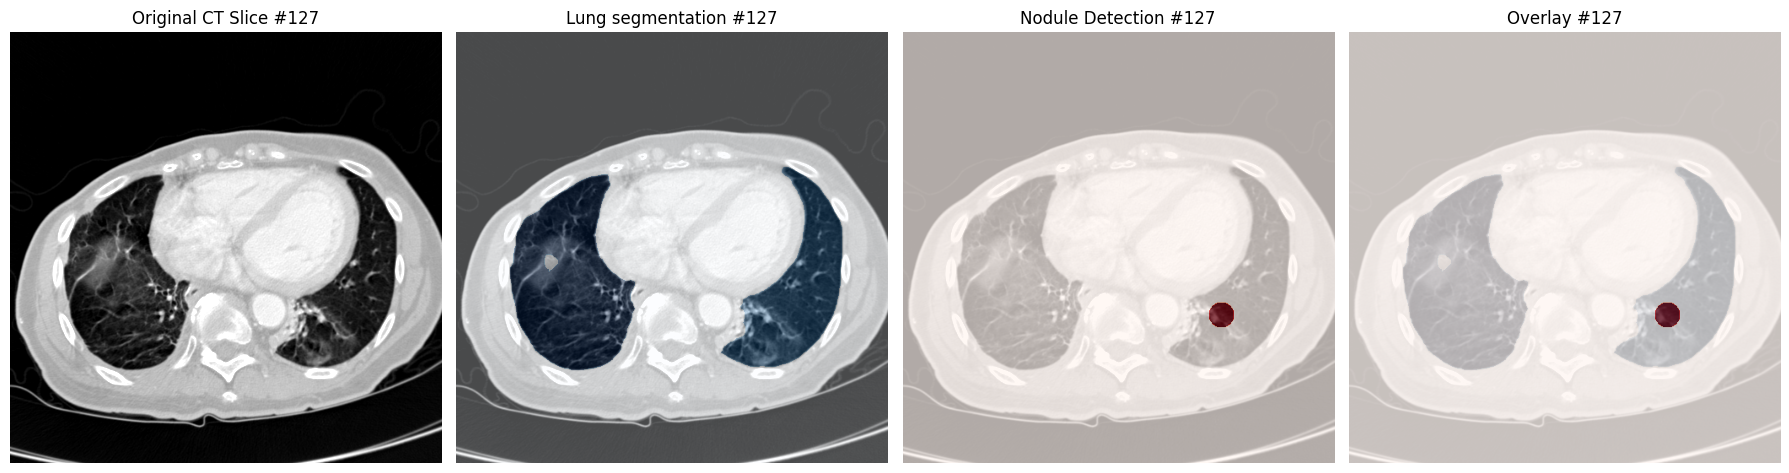

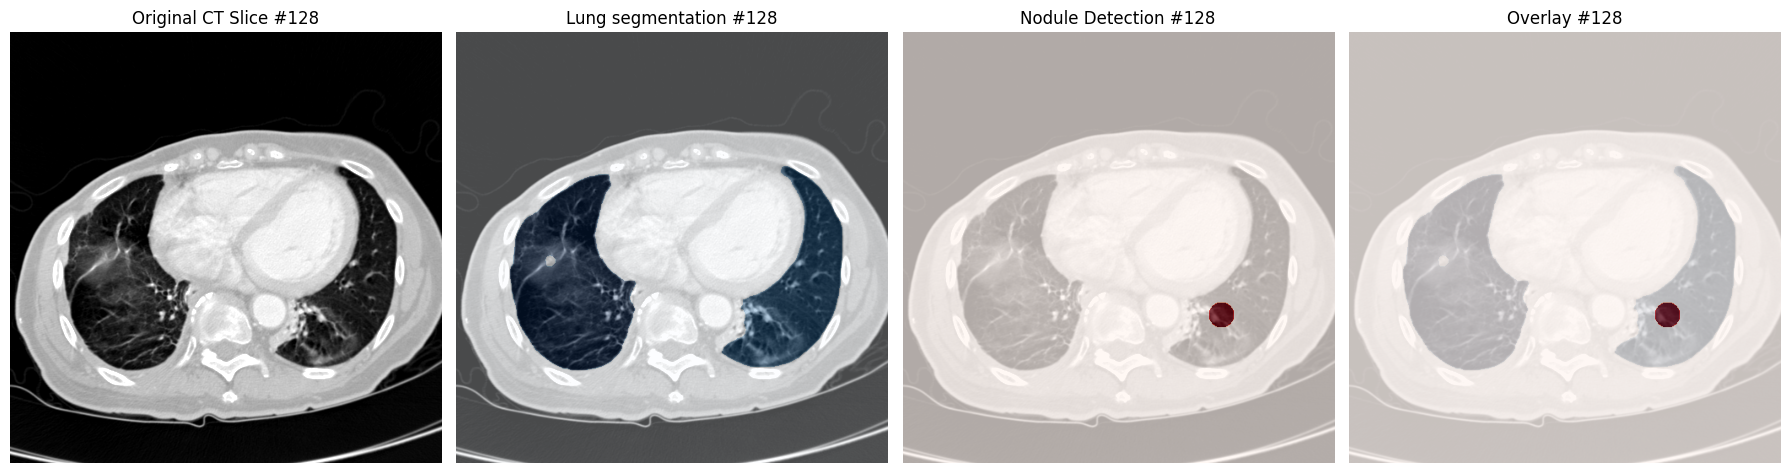

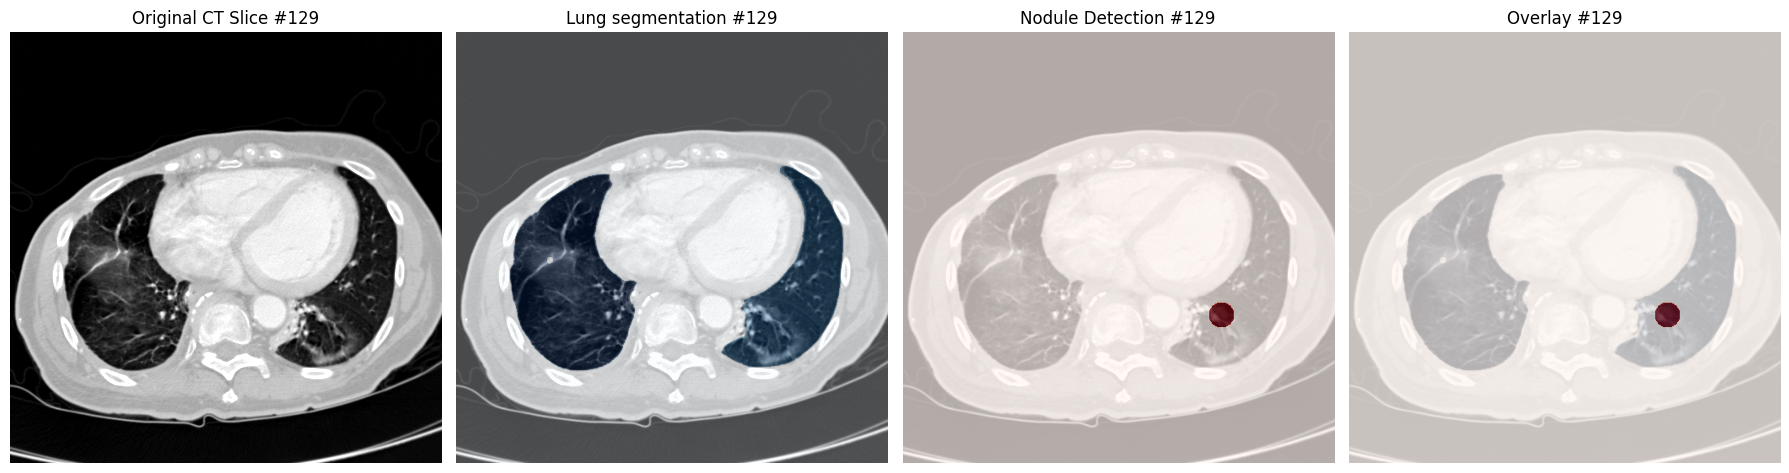

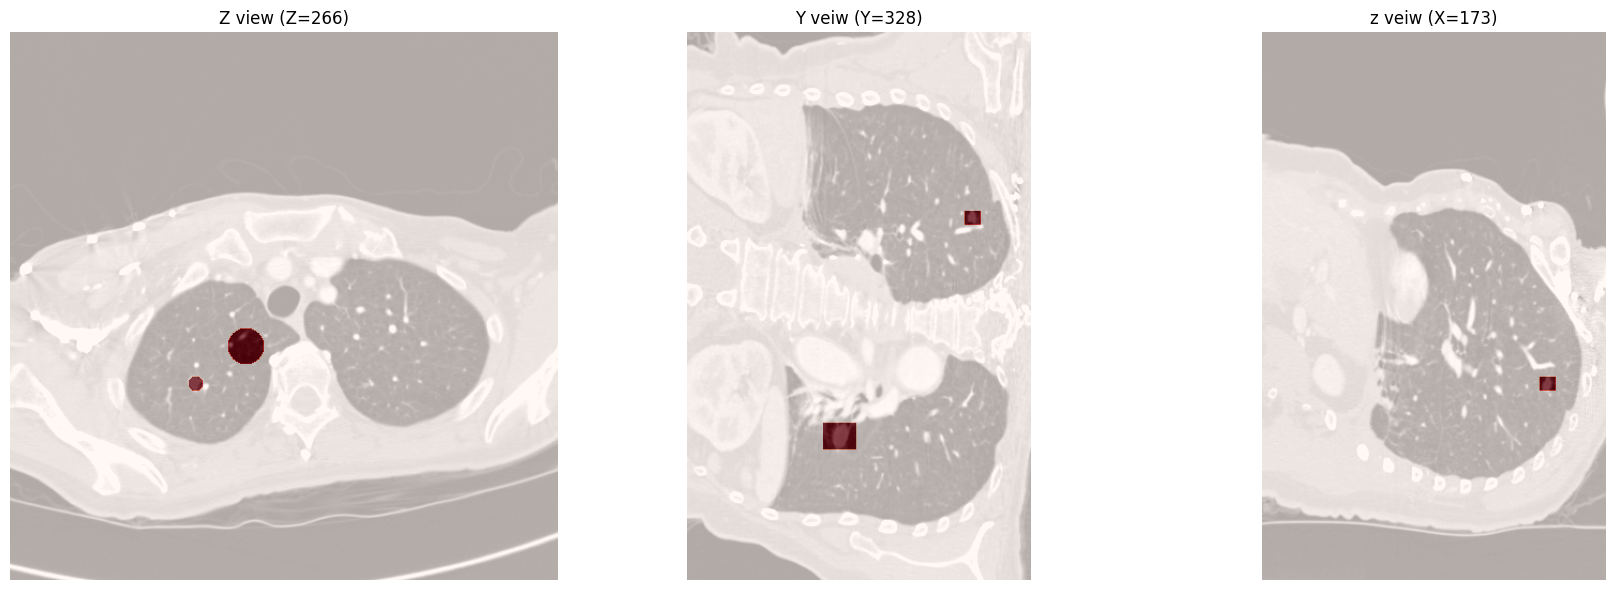

In [13]:
# Verificar nódulos

# Selecione um seriesuid
test_seriesuid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405"
ct_array, mask_array, spacing, ct_path = load_ct_and_mask(test_seriesuid)
annotations_df = pd.read_csv("/kaggle/input/luna16/annotations.csv")

# Gerar node_masks
nodule_masks = generate_nodule_masks(test_seriesuid, ct_array, annotations_df)

# Visualização
visualize_nodule_detection(test_seriesuid, ct_array, mask_array, nodule_masks, annotations_df)

# Limpeza do Dataset

In [14]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# --- Defina o caminho (modifique de acordo com seu caminho atual) ---
LUNA16_ANNOTATIONS_PATH = '/kaggle/input/luna16/annotations.csv'
LUNA16_INPUT_PATH = '/kaggle/input/luna16'
OUTPUT_DATA_PATH = 'output_cleaned_dataset' 
os.makedirs(OUTPUT_DATA_PATH, exist_ok=True)


annotations_df = pd.read_csv(LUNA16_ANNOTATIONS_PATH)
seriesuids = annotations_df['seriesuid'].unique()

# --- Divida o conjunto de treinamento e o conjunto de validação (o mesmo de antes) ---
train_seriesuids, val_seriesuids = train_test_split(seriesuids, test_size=0.2, random_state=42)

def check_ct_file_exists(seriesuid, luna16_input_path):
    """Verifique se o arquivo CT correspondente ao seriesuid existe"""
    for subset_index in range(5):
        ct_path = os.path.join(luna16_input_path, f'subset{subset_index}/subset{subset_index}/{seriesuid}.mhd')
        if os.path.exists(ct_path):
            return True 
    return False 

# --- Organizar o conjunto de treinamento SeriesUIDs ---
cleaned_train_seriesuids = []
excluded_train_seriesuids = []

for seriesuid in train_seriesuids:
    if check_ct_file_exists(seriesuid, LUNA16_INPUT_PATH):
        cleaned_train_seriesuids.append(seriesuid) 
    else:
        #print(f"警告: 訓練集 SeriesUID {seriesuid} CT 檔案遺失，已排除。") 
        excluded_train_seriesuids.append(seriesuid)


# --- Organize o conjunto de validação SeriesUIDs (a estrutura do código é a mesma do conjunto de treinamento) ---
cleaned_val_seriesuids = []
excluded_val_seriesuids = []

for seriesuid in val_seriesuids:
    if check_ct_file_exists(seriesuid, LUNA16_INPUT_PATH):
        cleaned_val_seriesuids.append(seriesuid) 
    else:
        excluded_val_seriesuids.append(seriesuid) 


# --- Armazene a lista limpa de SeriesUIDs na pasta de saída ---
output_train_list_path = os.path.join(OUTPUT_DATA_PATH, 'cleaned_train_seriesuids.txt')
output_val_list_path = os.path.join(OUTPUT_DATA_PATH, 'cleaned_val_seriesuids.txt')

with open(output_train_list_path, 'w') as f:
    for seriesuid in cleaned_train_seriesuids:
        f.write(f"{seriesuid}\n") # Escreva um seriesuid por linha

with open(output_val_list_path, 'w') as f:
    for seriesuid in cleaned_val_seriesuids:
        f.write(f"{seriesuid}\n") # Escreva um seriesuid por linha



In [15]:
import pandas as pd
import numpy as np
import os
import SimpleITK as sitk
import skimage.draw

# --- Defina o caminho (modifique de acordo com seu caminho atual) ---
LUNA16_ANNOTATIONS_PATH = '/kaggle/input/luna16/annotations.csv'
LUNA16_INPUT_PATH = '/kaggle/input/luna16'
OUTPUT_DATA_PATH = 'output_cleaned_dataset' 


annotations_df = pd.read_csv(LUNA16_ANNOTATIONS_PATH)


cleaned_train_list_path = os.path.join(OUTPUT_DATA_PATH, 'cleaned_train_seriesuids.txt')
cleaned_val_list_path = os.path.join(OUTPUT_DATA_PATH, 'cleaned_val_seriesuids.txt')

def load_seriesuids_from_txt(filepath):
    """Carregar uma lista de SeriesUIDs de um arquivo de texto"""
    seriesuids = []
    with open(filepath, 'r') as f:
        for line in f:
            seriesuid = line.strip() 
            if seriesuid: 
                seriesuids.append(seriesuid)
    return seriesuids

train_seriesuids = load_seriesuids_from_txt(cleaned_train_list_path) # Carregar a lista de conjuntos de treinamento limpos
val_seriesuids = load_seriesuids_from_txt(cleaned_val_list_path)     # Carregue a lista de conjuntos de validação limpa

# Criação do Gerador de Dados

In [16]:
# print("--- 資料準備開始 (單一 SeriesUID 測試) ---")

# test_seriesuid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760173137525888934217" # 選擇一個 seriesuid
# print(f"測試 SeriesUID: {test_seriesuid}")

# try:
#     ct_array, mask_array, spacing, ct_path = load_ct_and_mask(test_seriesuid, LUNA16_INPUT_PATH)
#     print(f"CT Array Shape: {ct_array.shape}, dtype: {ct_array.dtype}") # 檢查 CT shape 和 dtype
#     print(f"Lung Mask Array Shape: {mask_array.shape}, dtype: {mask_array.dtype}") # 檢查肺部 mask shape 和 dtype

#     preprocessed_ct_array = preprocess_ct_scan(ct_array, mask_array)
#     print(f"Preprocessed CT Array Shape: {preprocessed_ct_array.shape}, dtype: {preprocessed_ct_array.dtype}, range: [{preprocessed_ct_array.min()}, {preprocessed_ct_array.max()}]") # 檢查預處理後 CT shape, dtype 和灰度值範圍

#     nodule_masks_3d = generate_nodule_masks(test_seriesuid, ct_array, annotations_df, LUNA16_INPUT_PATH)
#     print(f"Nodule Masks 3D Shape: {nodule_masks_3d.shape}, dtype: {nodule_masks_3d.dtype}, sum: {nodule_masks_3d.sum()}") # 檢查結節 mask shape, dtype 和總和

#     scan_annotations = annotations_df[annotations_df['seriesuid'] == test_seriesuid]
#     print(f"Number of Annotations for {test_seriesuid}: {len(scan_annotations)}") # 檢查註解數量

#     if len(scan_annotations) > 0:
#         for _, nodule_annotation in scan_annotations.iterrows():
#             center_zyx = calculate_nodule_center(nodule_annotation, ct_array, ct_path)
#             print(f"  Nodule Center ZYX: {center_zyx}") # 檢查結節中心坐標

#             z_center = int(center_zyx[0])
#             z_start = max(0, z_center - SLICE_RANGE // 2)
#             z_end = min(ct_array.shape[0], z_center + SLICE_RANGE // 2 + 1)
#             print(f"  Slice Range: z_start={z_start}, z_end={z_end}") # 檢查切片範圍

#             for slice_index in range(z_start, z_end):
#                 input_slice = preprocessed_ct_array[slice_index]
#                 target_mask_slice = nodule_masks_3d[slice_index]

#                 if np.max(target_mask_slice) > 0:
#                     input_images_train.append(np.expand_dims(input_slice, axis=-1))
#                     target_masks_train.append(np.expand_dims(target_mask_slice, axis=-1))
#                     print(f"    Slice {slice_index}: 加入訓練集") # 確認切片加入訓練集

#     else:
#         print(f"  SeriesUID: {test_seriesuid}, 沒有結節註解，跳過")

# except Exception as e:
#     print(f"處理 seriesuid {test_seriesuid} 時發生錯誤: {e}")

# print("--- 單一 SeriesUID 測試完成 ---")

# # (暫時省略轉換為 NumPy 陣列和印出形狀的程式碼，先驗證單一 SeriesUID 流程)

# import matplotlib.pyplot as plt
# # --- (步驟 2.1 的程式碼，保持不變) ---

# print("--- 單一 SeriesUID 測試完成，開始可視化 ---")

# # 選擇要可視化的切片索引 (例如，結節中心切片 z_center)
# visualization_slice_index = z_center # 使用結節中心切片

# # 顯示原始 CT, 肺部 mask, 預處理 CT, 結節 mask
# plt.figure(figsize=(20, 5))

# plt.subplot(1, 4, 1)
# plt.imshow(ct_array[visualization_slice_index], cmap='gray')
# plt.title(f'Original CT Slice {visualization_slice_index}')

# plt.subplot(1, 4, 2)
# plt.imshow(mask_array[visualization_slice_index], cmap='gray')
# plt.title(f'Lung Mask Slice {visualization_slice_index}')

# plt.subplot(1, 4, 3)
# plt.imshow(preprocessed_ct_array[visualization_slice_index], cmap='gray')
# plt.title(f'Preprocessed CT Slice {visualization_slice_index}')

# plt.subplot(1, 4, 4)
# plt.imshow(nodule_masks_3d[visualization_slice_index], cmap='gray') # 或 cmap='Reds' 等
# plt.title(f'Nodule Mask Slice {visualization_slice_index}')

# plt.tight_layout()
# plt.show()

# print("--- 可視化完成 ---")
# print("資料準備程式碼 (單一 SeriesUID 測試) 執行完畢")

In [17]:
import numpy as np
import tensorflow as tf
import os
import cv2
import pandas as pd  
import SimpleITK as sitk 

class LunaDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, seriesuids_list, annotations_df, luna16_input_path,
                 batch_size=8, slice_range=3, img_size=(224, 224), augment=False):
        self.seriesuids_list = seriesuids_list
        self.annotations_df = annotations_df
        self.luna16_input_path = luna16_input_path
        self.batch_size = batch_size
        self.slice_range = slice_range
        self.img_size = img_size
        self.augment = augment
        self.indexes = np.arange(len(self.seriesuids_list))
        self.on_epoch_end()

    def __len__(self):
        # Aproximar número de batches
        return int(np.floor(len(self.seriesuids_list) / self.batch_size))

    def __getitem__(self, index):
        batch_seriesuids = self.seriesuids_list[index * self.batch_size:(index + 1) * self.batch_size]
        batch_input_images = []
        batch_target_labels = []

        for seriesuid in batch_seriesuids:
            try:
                # Carregar CT e mask
                ct_array, mask_array, spacing, ct_path = load_ct_and_mask(
                    seriesuid, self.luna16_input_path)
                preprocessed_ct_array = preprocess_ct_scan(ct_array, mask_array)
                nodule_masks_3d = generate_nodule_masks(
                    seriesuid, ct_array, self.annotations_df, self.luna16_input_path)
                scan_annotations = self.annotations_df[self.annotations_df['seriesuid'] == seriesuid]

                # Se há anotações de nódulo
                if len(scan_annotations) > 0:
                    for _, nodule_annotation in scan_annotations.iterrows():
                        center_zyx = calculate_nodule_center(
                            nodule_annotation, ct_array, ct_path)
                        z_center = int(center_zyx[0])
                        z_start = max(0, z_center - self.slice_range // 2)
                        z_end = min(ct_array.shape[0], z_center + self.slice_range // 2 + 1)

                        for slice_index in range(z_start, z_end):
                            input_slice = preprocessed_ct_array[slice_index]
                            target_mask_slice = nodule_masks_3d[slice_index]

                            if np.max(target_mask_slice) > 0:  # apenas slices com nódulo
                                # Redimensionar para IMG_SIZE
                                resized_slice = cv2.resize(
                                    input_slice, self.img_size,
                                    interpolation=cv2.INTER_LINEAR)
                                # Expandir e replicar canais
                                input_img = np.expand_dims(resized_slice, axis=-1)  # (H, W, 1)
                                input_img = np.repeat(input_img, 3, axis=-1)        # (H, W, 3)

                                # Data augmentation opcional
                                if self.augment:
                                    pass  # adicionar transformações aqui

                                batch_input_images.append(input_img)
                                batch_target_labels.append(1)

            except FileNotFoundError as e:
                print(f"LunaDataGenerator: CT faltando para {seriesuid}: {e}")
                continue
            except Exception as e:
                print(f"LunaDataGenerator: erro ao processar {seriesuid}: {e}")

        # Converter para numpy arrays
        batch_input_images = np.array(batch_input_images, dtype=np.float32)
        batch_target_labels = np.array(batch_target_labels, dtype=np.uint8)

        if len(batch_input_images) == 0:
            raise ValueError(f"Batch {index} está vazio.")

        return batch_input_images, batch_target_labels

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)


2025-04-29 18:59:19.137261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745953159.322719      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745953159.372928      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Validação do Gerador de Dados

In [18]:
# Crie uma instância do Data Generator com um pequeno número de seriesuids (para teste)
test_seriesuids = train_seriesuids[:10] # Por exemplo, obtenha os primeiros 10 seriesuids
test_data_generator = LunaDataGenerator(test_seriesuids, annotations_df, LUNA16_INPUT_PATH, batch_size=2, slice_range=3, augment=False)

/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.631047517458234322522264161877.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.171667800241622018839592854574.mhd
Batch 1 — imagens: (6, 224, 224, 3), dtype: float32
Batch 1 — labels: (6,), unique: [1]


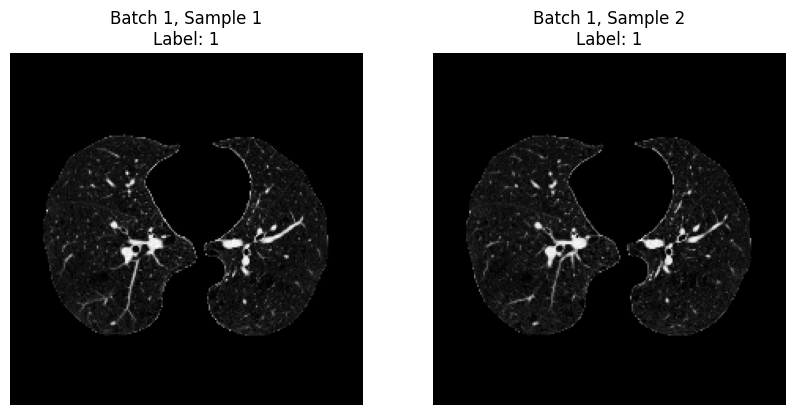

/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.961063442349005937536597225349.mhd
Batch 2 — imagens: (6, 224, 224, 3), dtype: float32
Batch 2 — labels: (6,), unique: [1]


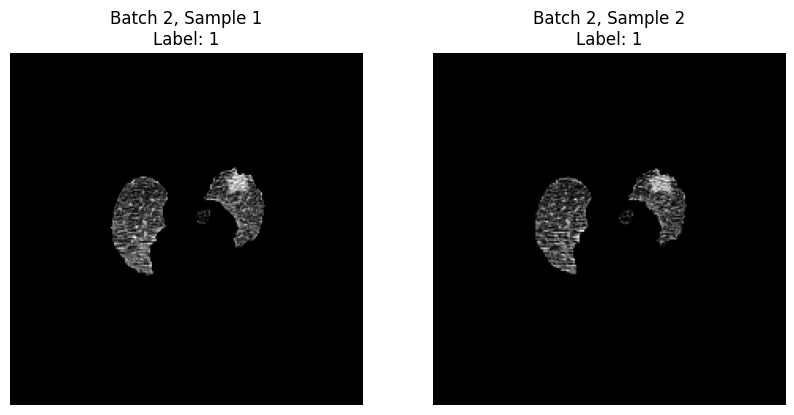

/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.192256506776434538421891524301.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.199670099218798685977406484591.mhd
Batch 3 — imagens: (21, 224, 224, 3), dtype: float32
Batch 3 — labels: (21,), unique: [1]


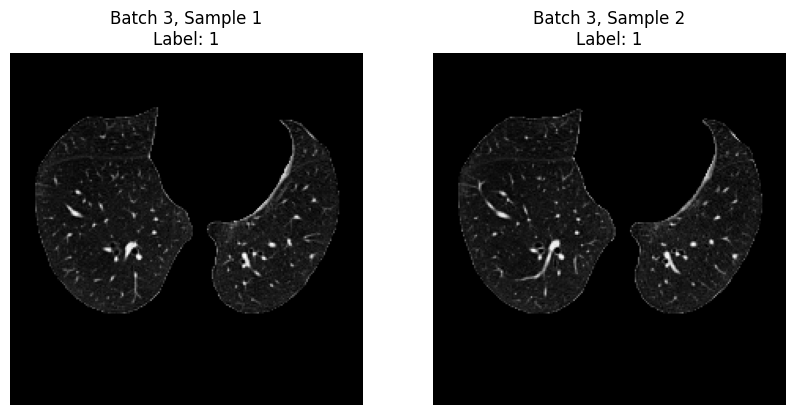

/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
Batch 4 — imagens: (12, 224, 224, 3), dtype: float32
Batch 4 — labels: (12,), unique: [1]


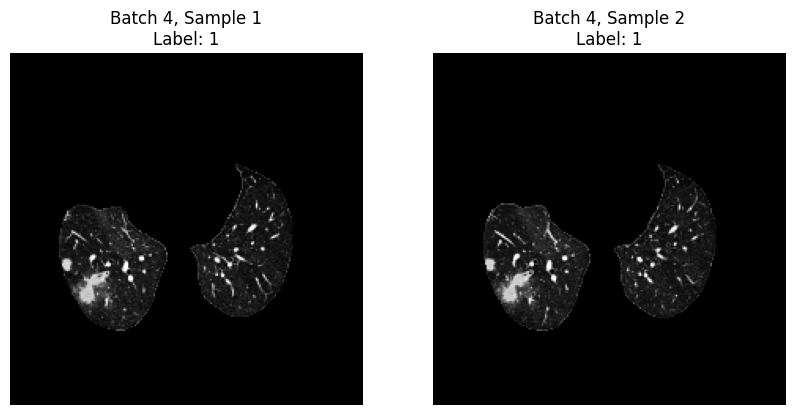

/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.202643836890896697853521610450.mhd
/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.183843376225716802567192412456.mhd
Batch 5 — imagens: (15, 224, 224, 3), dtype: float32
Batch 5 — labels: (15,), unique: [1]


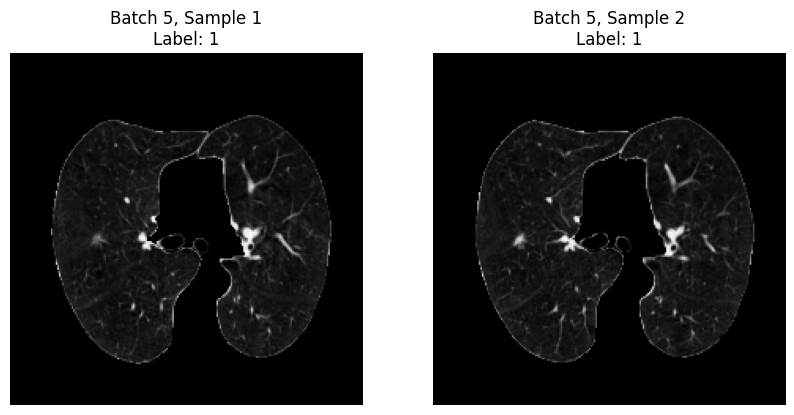

Visualização concluída.


In [19]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(5):
    batch_data = test_data_generator[i]
    if batch_data is None:
        print(f"Batch {i+1} vazio, pulando.")
        continue

    batch_input_images, batch_target_labels = batch_data
    print(f"Batch {i+1} — imagens: {batch_input_images.shape}, dtype: {batch_input_images.dtype}")
    print(f"Batch {i+1} — labels: {batch_target_labels.shape}, unique: {np.unique(batch_target_labels)}")

    # Visualizar até 2 amostras por batch
    num_samples_to_viz = min(len(batch_input_images), 2)
    plt.figure(figsize=(5 * num_samples_to_viz, 5))
    for j in range(num_samples_to_viz):
        plt.subplot(1, num_samples_to_viz, j+1)
        plt.imshow(batch_input_images[j][:, :, 0], cmap='gray')
        plt.title(f'Batch {i+1}, Sample {j+1}\nLabel: {batch_target_labels[j]}')
        plt.axis('off')
    plt.show()

print("Visualização concluída.")


# Construindo o Modelo

In [20]:

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping



# --- Hyperparâmetros ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
SLICE_RANGE = 3
EPOCHS = 20
LEARNING_RATE = 1e-4

# --- Geradores de dados ---
train_generator = LunaDataGenerator(
    train_seriesuids, annotations_df, LUNA16_INPUT_PATH,
    batch_size=BATCH_SIZE, slice_range=SLICE_RANGE, augment=True
)
val_generator = LunaDataGenerator(
    val_seriesuids, annotations_df, LUNA16_INPUT_PATH,
    batch_size=BATCH_SIZE, slice_range=SLICE_RANGE, augment=False
)

# --- Construção do modelo EfficientNetB0 ---
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False  # Congelar backbone inicialmente

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- Callbacks ---
callbacks = [
    ModelCheckpoint('efficientnet_luna16_best.keras', save_best_only=True, monitor='val_accuracy', mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

# --- Treinamento ---
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

# --- Avaliação ---
results = model.evaluate(val_generator)
print("Resultados no conjunto de validação:")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# --- Fine-tuning (opcional) ---
# Descongelar última parte do backbone para ajuste fino
base_model.trainable = True
for layer in base_model.layers[:-20]:  # manter camadas iniciais congeladas
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),  # LR menor
    loss='binary_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 10
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=fine_tune_epochs,
    callbacks=callbacks
)

# --- Salvando modelo final ---
model.save('efficientnet_luna16_final.keras')


I0000 00:00:1745953193.796081      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.631047517458234322522264161877.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.171667800241622018839592854574.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.961063442349005937536597225349.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.192256506776434538421891524301.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.199670099218798685977406484591.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.202643836890896697853521610450.mhd
/kaggle/input/luna16/subset1/subset1/1.3.6.1.4

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.277662902666135640561346462196.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235.mhd
/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.584871944187559733312703328980.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.137375498893536422914241295628.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.199220738144407033276946096708.mhd
/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.179162671133894061547290922949.mhd
/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.272961322147784625028175033640.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.124663713663969377020085460568.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4

I0000 00:00:1745953402.371716      64 service.cc:148] XLA service 0x7bd4fc002bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745953402.372517      64 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745953404.276075      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.479402560265137632920333093071.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.272190966764020277652079081128.mhd
/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.146987333806092287055399155268.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.339142594937666268384335506819.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.267519732763035023633235877753.mhd
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1:34:11 188s/step - accuracy: 0.8039 - loss: 0.6842

I0000 00:00:1745953414.540293      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.206539885154775002929031534291.mhd
/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.390513733720659266816639651938.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433161353885866806005.mhd
/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.922852847124879997825997808179.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.252634638822000832774167856951.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.187108608022306504546286626125.mhd
 2/31 ━━━━━━━━━━━━━━━━━━━━ 7:31 16s/step - accuracy: 0.7967 - loss: 0.6838    /kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310548927038333190233889983845.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.199

E0000 00:00:1745966245.082827      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745966245.292716      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188209889686363159853715266493.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.244204120220889433826451158706.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.144883090372691745980459537053.mhd
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1:10:34 141s/step - accuracy: 0.0889 - loss: 1.8401/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.265453131727473342790950829556.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.149463915556499304732434215056.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.237428977311365557972720635401.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410.mhd


E0000 00:00:1745966263.295948      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745966263.506068      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111.mhd
/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.231002159523969307155990628066.mhd
 2/31 ━━━━━━━━━━━━━━━━━━━━ 8:34 18s/step - accuracy: 0.1075 - loss: 1.8442    /kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.438308540025607517017949816111.mhd
/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.616033753016904899083676284739.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217589936421986638139451480826.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.212346425055214308006918165305.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.443400977949406454649939526179.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd


E0000 00:00:1745966282.697929      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745966282.907570      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313605260055394498989743099991.mhd
/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.861997885565255340442123234170.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.179730018513720561213088132029.mhd
/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262002764211589185953.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037.mhd
 3/31 ━━━━━━━━━━━━━━━━━━━━ 8:31 18s/step - accuracy: 0.1138 - loss: 1.8369/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230.mhd
/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.797637294244261543517154417124.mhd
/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.1415113

E0000 00:00:1745966296.966845      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745966297.176623      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196.mhd
/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.561458563853929400124470098603.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.321465552859463184018938648244.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.283733738239331719775105586296.mhd
 4/31 ━━━━━━━━━━━━━━━━━━━━ 7:38 17s/step - accuracy: 0.1139 - loss: 1.8336/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.227885601428639043345478571594.mhd


E0000 00:00:1745966311.835103      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745966312.044755      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.252358625003143649770119512644.mhd
/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.259123825760999546551970425757.mhd
 5/31 ━━━━━━━━━━━━━━━━━━━━ 7:07 16s/step - accuracy: 0.1136 - loss: 1.8273/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.267957701183569638795986183786.mhd
/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760173137525888934217.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.302557165094691896097534021075.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.822128649427327893802314908658.mhd
/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.6909299

E0000 00:00:1745966334.773682      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745966334.983275      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.756684168227383088294595834066.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.153536305742006952753134773630.mhd
/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.306948744223170422945185006551.mhd
 7/31 ━━━━━━━━━━━━━━━━━━━━ 5:55 15s/step - accuracy: 0.1180 - loss: 1.8120/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404364125369979066736354549484.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.2252276

E0000 00:00:1745966401.762048      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745966401.972476      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.265775376735520890308424143898.mhd
/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.173101104804533997398137418032.mhd
10/31 ━━━━━━━━━━━━━━━━━━━━ 6:04 17s/step - accuracy: 0.1204 - loss: 1.7927/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.115386642382564804180764325545.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.640729228179368154416184318668.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.216882370221919561230873289517.mhd
/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.631047517458234322522264161877.mhd
11/31 ━━━━━━━━━━━━━━━━━━━━ 5:33 17s/step - accuracy: 0.1218 - loss: 1.7838/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.171667800241622018839592854574.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311.mhd
/kag

E0000 00:00:1745966480.438592      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745966480.648546      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.458525794434429386945463560826.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.324567010179873305471925391582.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.281489753704424911132261151767.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228.mhd
14/31 ━━━━━━━━━━━━━━━━━━━━ 5:07 18s/step - accuracy: 0.1270 - loss: 1.7605/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.214800939017429618305208626314.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.148447286464082095534651426689.mhd
15/31 ━━━━━━━━━━━━━━━━━━━━ 4:31 17s/step - accuracy: 0.1285 - loss: 1.7525/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
/kag

E0000 00:00:1745966549.649816      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745966549.860382      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.250397690690072950000431855143.mhd
/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.270215889102603268207599305185.mhd
18/31 ━━━━━━━━━━━━━━━━━━━━ 3:52 18s/step - accuracy: 0.1340 - loss: 1.7291/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.336225579776978874775723463327.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.254254303842550572473665729969.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.127965161564033605177803085629.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.192419869605596446455526220766.mhd
/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.655242448149322898770987310561.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.123697637451437522065941162930.mhd
/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.3001462

E0000 00:00:1745966568.843615      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745966569.051913      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.278010349511857248000260557753.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.227796349777753378641347819780.mhd
19/31 ━━━━━━━━━━━━━━━━━━━━ 3:35 18s/step - accuracy: 0.1358 - loss: 1.7217/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.208737629504245244513001631764.mhd
/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.268992195564407418480563388746.mhd
20/31 ━━━━━━━━━━━━━━━━━━━━ 3:09 17s/step - accuracy: 0.1374 - loss: 1.7145/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280.mhd
/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.310395752124284049604069960014.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.204303454658845815034433453512.mhd
/kag

In [21]:
# Obtém probabilidades para todo o conjunto de validação
probs = model.predict(val_generator)  
print("Shape das predições:", probs.shape)  # ex: (N, 1)
print("Primeiras 5 probabilidades:\n", probs[:10])

# Converte em rótulos binários
labels = (probs >= 0.5).astype(int)
print("Primeiros 5 rótulos:", labels[:10])


/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.161855583909753609742728521805.mhd
/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.826829446346820089862659555750.mhd
/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982792863757268101375.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.275007193025729362844652516689.mhd
/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.287560874054243719452635194040.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217955041973656886482758642958.mhd
/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.145759169833745025756371695397.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4

In [22]:
# --- Salvando modelo final ---
model.save('efficientnet_luna16_final.keras')


In [23]:
results = model.evaluate(val_generator)
accuracy = results[1]  # Índice 1 corresponde à acurácia, pois foi especificada como a primeira métrica
print(f"Acurácia no conjunto de validação: {accuracy:.4f}")


/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.161855583909753609742728521805.mhd
/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.826829446346820089862659555750.mhd
/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982792863757268101375.mhd
/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.275007193025729362844652516689.mhd
/kaggle/input/luna16/subset4/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.287560874054243719452635194040.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217955041973656886482758642958.mhd
/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.145759169833745025756371695397.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd
/kaggle/input/luna16/subset3/subset3/1.3.6.1.4